# Index Number = 180411K 
# EN2550 2021: Object Counting on a Convey Belt

### Submitted on: July 10, 2021

In [40]:
import cv2 as cv
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

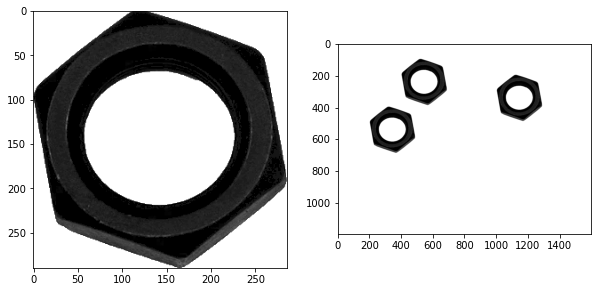

In [41]:
template_im = cv.imread(r'template.png', cv.IMREAD_GRAYSCALE)
belt_im = cv.imread(r'belt.png', cv.IMREAD_GRAYSCALE)
fig, ax = plt. subplots(1,2,figsize=(10,10))
ax[0].imshow(template_im, cmap='gray')
ax[1].imshow(belt_im, cmap='gray')
plt.show()

# Part 1

### Otsu’s thresholding

In [42]:
th_t, img_t = cv.threshold(template_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
th_b, img_b = cv.threshold(belt_im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)

### Morphological closing

In [43]:
kernel=np.ones((3,3),np.uint8)
closing_t = cv.morphologyEx(img_t, cv.MORPH_CLOSE, kernel) # Dilation followed by Erosion.
closing_b = cv.morphologyEx(img_b, cv.MORPH_CLOSE, kernel)

### Connected component analysis

........Template image.......
No.of connected components =  2


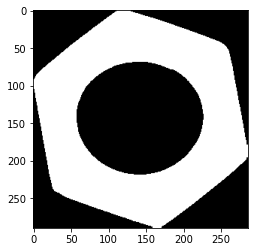

statistics =  
 [[    0     0   286   290 42290]
 [    0     0   286   290 40650]]
Centroids =  
 [[142.18770395 145.19172381]
 [142.82489545 143.780369  ]]
.........Belt image.........
No.of connected components =  4


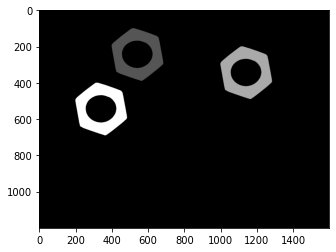

statistics =  
 [[      0       0    1600    1200 1798161]
 [    400     100     286     290   40613]
 [   1000     200     286     290   40613]
 [    200     400     286     290   40613]]
Centroids =  
 [[ 807.85728475  614.56805258]
 [ 542.82567158  243.78479797]
 [1142.82567158  343.78479797]
 [ 342.82567158  543.78479797]]


In [44]:
retval_t, labels_t, stats_t, centroids_t = cv.connectedComponentsWithStats(closing_t)
retval_b, labels_b, stats_b, centroids_b =cv.connectedComponentsWithStats(closing_b)

print('........Template image.......')
print("No.of connected components = ", retval_t)
plt.imshow(labels_t.astype('uint8'), cmap ='gray')
plt.show()
print("statistics = ",'\n', stats_t) 
print("Centroids = ",'\n', centroids_t)

print('.........Belt image.........')
print("No.of connected components = ", retval_b)
plt.imshow(labels_b.astype('uint8'), cmap ='gray')
plt.show()
print("statistics = ",'\n', stats_b) 
print("Centroids = ",'\n', centroids_b)

### **How many connected components are detected in each image?**
#### Template Image = 2 (including background)
#### Belt Image = 4 (including background)

### **What are the statistics? Interpret these statistics.**
#### Statistics  give the properties of the connected component such as  the horizontal and verical size of bounding box, total area of connected component and many more. Statistics are accessed via stats(label, COLUMN). Where COLUMN is one of ConnectedComponentsTypes, selecting the statistic.

#### Col 1: cv.CC_STAT_LEFT: the leftmost (x) coordinate which is the inclusive start of the bounding box in the horizontal direction.
#### Col 2: cv.CC_STAT_TOP: the topmost (y) coordinate which is the inclusive start of the bounding box in the vertical direction.
#### Col 3: cv.CC_STAT_WIDTH: the horizontal size of the bounding box.
#### Col 4: cv.CC_STAT_HEIGHT: the vertical size of the bounding box.
#### Col 5: cv.CC_STAT_AREA: the total area (in pixels) of the connected component.

### **What are the centroids?**
#### Each row gives the (x,y) coordinates of centroid of the corresponding connected component.

### Find contours

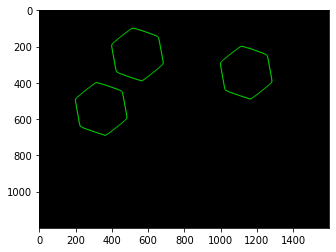

Smilarity with contour  1  =  0.00010071698397173812
Smilarity with contour  2  =  0.00010071698397950968
Smilarity with contour  3  =  0.00010071698397506879
Number of Nuts = 3


In [47]:
#cv.CHAIN_APPROX_SIMPLE removes all redundant points and compresses the contour, thereby saving memory.
# here we only recieve outer contours
contours_t, hierarchy_t = cv.findContours(closing_t, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
contours_b, hierarchy_b =cv.findContours(closing_b, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)

# Visualizing contours
#Contours is a Python list of all the contours in the image. Each individual contour is a Numpy array of (x,y) coordinates of boundary points of the object.
im_contours_belt = np.zeros((belt_im.shape[0],belt_im.shape[1],3), np.uint8)
conts = cv.drawContours(im_contours_belt, contours_b, -1, (0,255,0), 3).astype('uint8')
plt.imshow(conts)
plt.show()

label = 1 # remember that the label of the background is 0
belt = ((labels_b >= label)*255).astype('uint8')
NoOfNuts=0
belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE)
for j,c in enumerate(belt_cont):
    print('Smilarity with contour ',j+1,' = ',cv.matchShapes(contours_t[0], c, cv.CONTOURS_MATCH_I1, 0.0))
    NoOfNuts+=1
    #he lower the result, the better match it is. It is calculated based on the hu-moment values
print ('Number of Nuts =',NoOfNuts)

# Part 2

### Frame tracking through image moments.

In [48]:
cnt=contours_b[1]
ca = cv.contourArea(cnt)
print('area = ', ca)

area =  60059.5


In [49]:
M = cv.moments(cnt)
cx = int(M['m10']/M['m00'])# extract x coordinates of the centroid of contours_b[1]
cy = int(M['m01']/M['m00'])#extract y coordinates of the centroid of contours_b[1]
print('cx = ',cx,'cy = ', cy)

cx =  1142 cy =  343


In [50]:
count=1
object_prev_frame = np.array([cx,cy,ca,count])

In [51]:
delta_x = 15

# Part 3

### 1) Implement the function get_indexed_image, which takes an image as the input, performs thresholding, closing, and connected component analysis and return retval, labels, stats, centroids. (Grading)


In [52]:
def get_indexed_image(im):
    th, img = cv.threshold(im,0,255,cv.THRESH_BINARY_INV+cv.THRESH_OTSU)
    kernel=np.ones((3,3),np.uint8)
    closing= cv.morphologyEx(img, cv.MORPH_CLOSE, kernel) # Dilation followed by Erosion.
    retval, labels, stats, centroids = cv.connectedComponentsWithStats(closing)
    return retval, labels, stats, centroids

### 2) Implement the function is_new, which checks the dissimilarity between 2 vectors. (Grading)


In [62]:
def is_new(a, b, delta, i):
    for ind in range(i.shape[0]):
        index=i[ind] #colomn to be compared
        b_val= b[index] #corresponding value in b array
        delta_val=delta[index] #corresponding value in delta array
        for row in a: # iterating for each row in a 
            if (abs(row[index]-b_val)) > delta_val:
                return False    
    return True

In [63]:
 # check is_new expected answer False
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
assert is_new(a, b, delta, i) == False, " Check the function "

### 3) . If the array a is in the shape of (number of nuts , len(object_prev_frame)) ( i.e. array a is made by stacking all the object_prev_frame for each frame. If b is in the form of [cx, cy, ca, count], write the function prev_index to find the index of a particular nut in the previous frame. (Grading)


In [66]:
def prev_index(a, b, delta, i):
    index = -1
    i_val=i[0]
    b_val=b[i_val]
    delta_val=delta[i_val]
    for row_index in range(a.shape[0]):
        if abs(a[row_index][i_val]-b_val)<delta_val:
            return row_index
    return index


In [67]:
# check prev_index expected answer 1
a = np.array([[1.36100e+03, 5.53000e+02, 5.99245e+04, 2.00000e+00],
[7.61000e+02, 4.53000e+02, 5.99385e+04, 1.00000e+00],
[1.55200e+03, 2.43000e+02, 6.00585e+04, 3.00000e+00]])
b = np.array([7.51000e+02, 4.53000e+02, 5.99385e+04, 3.00000e+00])
delta = np.array([delta_x])
i = np.array([0])
assert prev_index(a,b,delta,i) == 1, " Check the function "

### load and access each frame of a video

In [97]:
cap = cv.VideoCapture('conveyor_with_rotation.mp4') # give the correct path here
setOfFrames=[]
while cap.isOpened():
    ret, frame = cap.read()
    if not ret:
        print("Can't receive frame (stream end?). Exiting ...")
        break
    setOfFrames.append(frame)
    if cv.waitKey(1) == ord('q'):
        break
cap.release()
cv.destroyAllWindows()
print('Finished getting frames')

Can't receive frame (stream end?). Exiting ...
Finished getting frames


# Part 4

###  Implement a code to detect hexagonal nuts in a moving convey belt. (Grading)

In [98]:
contour_Plots=[]
#excecuting for each frame
for frame in setOfFrames: 
    grey=cv.cvtColor(frame,cv.COLOR_BGR2GRAY) #convering to gray scale
    retval, labels, stats, centroids= get_indexed_image(grey) # get label image
    belt = ((labels >= 1)*255).astype('uint8')
    belt_cont, template_hierarchy = cv.findContours(belt, cv.RETR_EXTERNAL, cv.CHAIN_APPROX_SIMPLE) #Find contours
    im_contours_belt = np.zeros((belt.shape[0],belt.shape[1],3), np.uint8) #Initiate a 3-D array with zeros to draw contours
    conts = cv.drawContours(im_contours_belt, belt_cont, -1, (0,255,0), 3).astype('uint8') #Draw contours
    contour_Plots.append(conts)

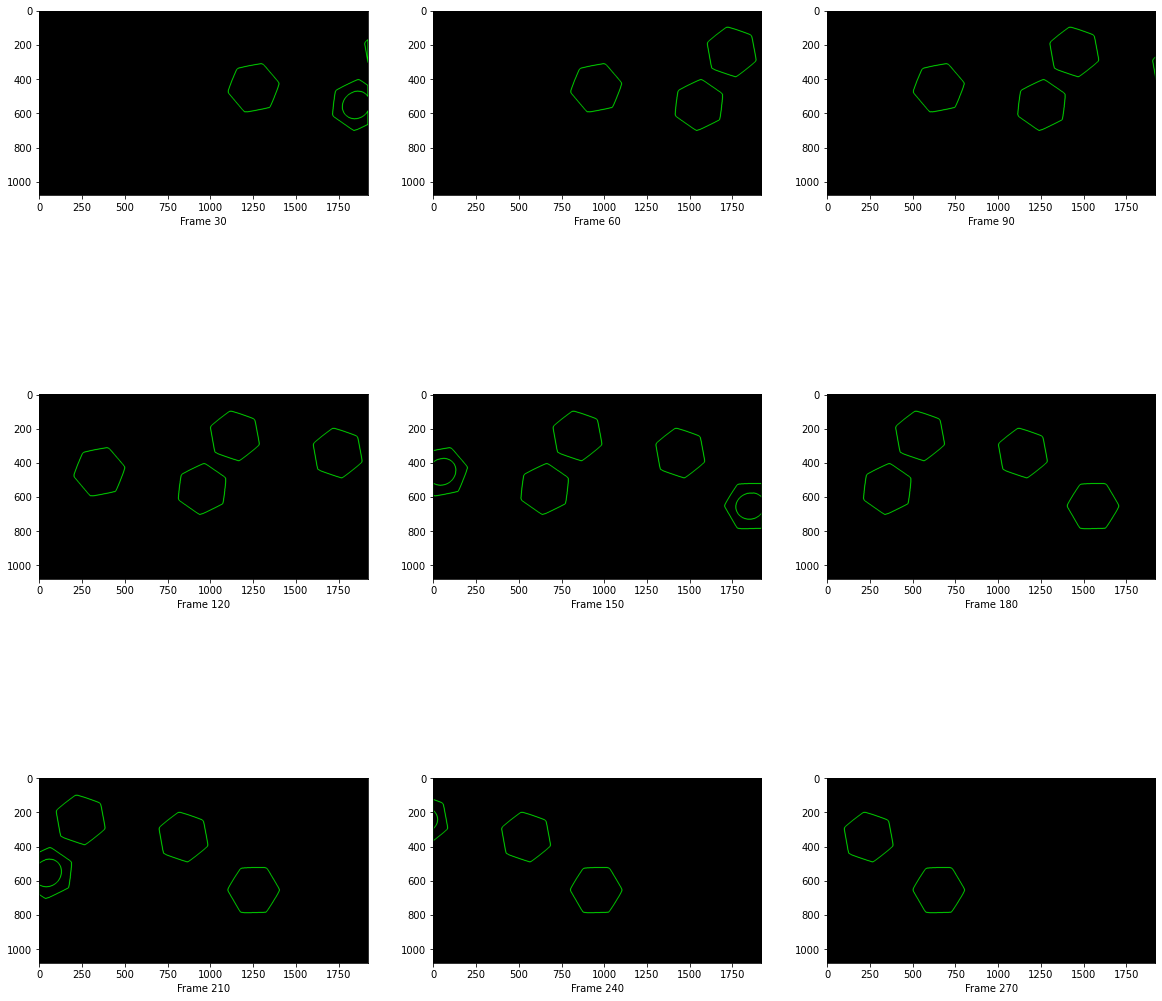

In [99]:
# visualize contour plots 
plt.figure(figsize=(20,20))
increment=0
for i in range(1,len(setOfFrames)):
    if i%30 ==0: # As there are 280 frames i plot 9 out of them at 30 frame gap
        plt.subplot(3,3,increment+1)
        plt.imshow(contour_Plots[i])
        plt.xlabel("Frame " + str(i))
        increment+=1
plt.show()

# Part 5